In [18]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from io import BytesIO
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.markers import MarkerStyle
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen, add_image
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
from matplotlib.patheffects import withStroke, Normal
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer.utils import FontManager
import matplotlib.patheffects as path_effects
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from sklearn.cluster import KMeans
import warnings
from highlight_text import ax_text, fig_text
from PIL import Image
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
from scipy.spatial import ConvexHull

#modify the dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


#custom colors

green = '#69f900'
red = '#ff4b44'
blue = '#00a0de'
violet = '#a369ff'
bg_color= '#f5f5f5'
line_color= '#000000'
# bg_color= '#000000'
# line_color= '#ffffff'
col1 = '#ff4b44'
col2 = '#00a0de'

In [19]:
match_html_path = r"C:\Users\gerald wangai\Downloads\Manchester City 3-4 Al Hilal - FIFA Club World Cup 2025 Live.html"
# Put the Fotmob matchId here
fotmob_matchId = 4506298

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def filter_json_data(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_data = data["matchCentreData"]["events"]
    teams_data = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_data = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_data, players_df, teams_data


json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_data, players_df, teams_data = filter_json_data(data)

df = pd.DataFrame(events_data)
dfp = pd.DataFrame(players_df)


#create csv files

df.to_csv("E:\important\Coding\Python Coding\Football Analytics/event_data.csv")
dfp.to_csv("E:\important\Coding\Python Coding\Football Analytics/player_data.csv")

df=pd.read_csv("E:\important\Coding\Python Coding\Football Analytics/event_data.csv")

dfp=pd.read_csv("E:\important\Coding\Python Coding\Football Analytics/player_data.csv")


# Extract the 'displayName' value
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")
df['qualifiers'] = df['qualifiers'].str.extract(r"'displayName': '([^']+)")

In [20]:
df.head()

,Unnamed: 0,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,isGoal,cardType
0,0,2.825188e+09,2,0,0.0,4975,0.0,0.0,0,FirstHalf,Start,Successful,NaN,[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2.825188e+09,2,0,0.0,167,0.0,0.0,0,FirstHalf,Start,Successful,NaN,[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.825188e+09,3,0,0.0,167,50.0,50.0,0,FirstHalf,Pass,Successful,Longball,"[91, 117, 127, 35, 38, 215, 218]",True,77464.0,19.3,49.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2.825188e+09,4,0,7.0,167,33.3,51.5,0,FirstHalf,Pass,Successful,PassEndX,"[91, 119, 117, 127, 205, 36, 38, 217, 218]",True,121774.0,87.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2.825188e+09,5,0,12.0,167,87.0,19.0,0,FirstHalf,Pass,Successful,HeadPass,"[91, 119, 117, 30, 139, 205, 36, 38, 217, 218]",True,315227.0,90.6,6.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df.columns

Index(['Unnamed: 0', 'id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
       'goalMouthZ', 'goalMouthY', 'isShot', 'isGoal', 'cardType'],
      dtype='object')

In [16]:
#columns_to_drop=['Unnamed: 0','satisfiedEventsTypes', 'isTouch','relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
       #'goalMouthZ', 'goalMouthY', 'isShot', 'isGoal', 'cardType']

#df=df.drop(columns=columns_to_drop, inplace=True)

In [22]:
mancity_df=df[df['teamId']==167]

In [23]:
mancity_df.head()

,Unnamed: 0,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,isGoal,cardType
1,1,2.825188e+09,2,0,0.0,167,0.0,0.0,0,FirstHalf,Start,Successful,NaN,[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.825188e+09,3,0,0.0,167,50.0,50.0,0,FirstHalf,Pass,Successful,Longball,"[91, 117, 127, 35, 38, 215, 218]",True,77464.0,19.3,49.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2.825188e+09,4,0,7.0,167,33.3,51.5,0,FirstHalf,Pass,Successful,PassEndX,"[91, 119, 117, 127, 205, 36, 38, 217, 218]",True,121774.0,87.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2.825188e+09,5,0,12.0,167,87.0,19.0,0,FirstHalf,Pass,Successful,HeadPass,"[91, 119, 117, 30, 139, 205, 36, 38, 217, 218]",True,315227.0,90.6,6.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2.825188e+09,6,0,14.0,167,90.6,6.3,0,FirstHalf,Pass,Successful,PassEndY,"[91, 119, 117, 30, 139, 205, 36, 37, 217, 218]",True,397821.0,93.6,15.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# merge the player data with the event data

mancity_df=pd.merge(mancity_df, dfp, on='playerId')

In [25]:
mancity_df.head()

,Unnamed: 0_x,id,eventId,minute,second,teamId_x,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,isGoal,cardType,Unnamed: 0_y,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId_y
0,2,2.825188e+09,3,0,0.0,167,50.0,50.0,0,FirstHalf,Pass,Successful,Longball,"[91, 117, 127, 35, 38, 215, 218]",True,77464.0,19.3,49.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,19,Ilkay Gündogan,MC,180,80,34,True,False,home,"{'possession': {'0': 1.0, '1': 2.0, '4': 3.0, ...",303139.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",58.0,NaN,NaN,NaN,167
1,3,2.825188e+09,4,0,7.0,167,33.3,51.5,0,FirstHalf,Pass,Successful,PassEndX,"[91, 119, 117, 127, 205, 36, 38, 217, 218]",True,121774.0,87.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,31,Ederson,GK,188,86,31,True,False,home,"{'totalSaves': {'124': 1.0, '133': 1.0}, 'coll...",NaN,NaN,NaN,NaN,NaN,NaN,167
2,4,2.825188e+09,5,0,12.0,167,87.0,19.0,0,FirstHalf,Pass,Successful,HeadPass,"[91, 119, 117, 30, 139, 205, 36, 38, 217, 218]",True,315227.0,90.6,6.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,9,Erling Haaland,FW,195,88,24,True,False,home,"{'possession': {'0': 4.0, '4': 1.0, '13': 1.0,...",394749.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167
3,5,2.825188e+09,6,0,14.0,167,90.6,6.3,0,FirstHalf,Pass,Successful,PassEndY,"[91, 119, 117, 30, 139, 205, 36, 37, 217, 218]",True,397821.0,93.6,15.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,26,Savinho,AMC,179,66,21,True,False,home,"{'possession': {'0': 3.0, '2': 1.0, '3': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,167
4,6,2.825188e+09,7,0,15.0,167,93.6,15.7,0,FirstHalf,Pass,Successful,PassEndY,"[91, 119, 117, 30, 205, 35, 38, 217, 218]",True,315227.0,93.4,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,9,Erling Haaland,FW,195,88,24,True,False,home,"{'possession': {'0': 4.0, '4': 1.0, '13': 1.0,...",394749.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167


In [26]:
names=mancity_df['name'].unique()

In [27]:
names

array(['Ilkay Gündogan', 'Ederson', 'Erling Haaland', 'Savinho',
       'Josko Gvardiol', 'Tijjani Reijnders', 'Rúben Dias',
       'Rayan Aït-Nouri', 'Jérémy Doku', 'Matheus Nunes',
       'Bernardo Silva', 'Rodri', 'Nathan Aké', 'Manuel Akanji',
       'Omar Marmoush', 'Rayan Cherki', 'Phil Foden'], dtype=object)

In [28]:
reijinders_df=mancity_df[mancity_df['name']=='Tijjani Reijnders']

In [29]:
reijinders_df.head()

,Unnamed: 0_x,id,eventId,minute,second,teamId_x,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,isGoal,cardType,Unnamed: 0_y,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId_y
16,26,2.825189e+09,19,1,2.0,167,23.0,62.8,1,FirstHalf,Pass,Successful,PassEndY,"[91, 117, 30, 36, 38, 215, 218]",True,343382.0,24.2,33.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167
18,28,2.825189e+09,21,1,10.0,167,47.3,58.4,1,FirstHalf,Pass,Successful,PassEndX,"[91, 119, 117, 30, 36, 37, 216, 218]",True,343382.0,53.7,77.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167
28,39,2.825189e+09,31,1,47.0,167,59.0,41.1,1,FirstHalf,Pass,Successful,Zone,"[91, 119, 117, 30, 36, 37, 216, 218]",True,343382.0,61.2,76.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167
39,58,2.825189e+09,42,2,41.0,167,66.8,4.2,2,FirstHalf,BallRecovery,Successful,NaN,[93],False,343382.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167
40,59,2.825189e+09,43,2,41.0,167,61.0,4.7,2,FirstHalf,Pass,Successful,PassEndY,"[91, 117, 30, 35, 37, 216, 218]",True,343382.0,37.6,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167


In [30]:
reijinders_pass_events=reijinders_df[reijinders_df['type']=='Pass']

In [31]:
reijinders_pass_events.head()

,Unnamed: 0_x,id,eventId,minute,second,teamId_x,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,isGoal,cardType,Unnamed: 0_y,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId_y
16,26,2.825189e+09,19,1,2.0,167,23.0,62.8,1,FirstHalf,Pass,Successful,PassEndY,"[91, 117, 30, 36, 38, 215, 218]",True,343382.0,24.2,33.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167
18,28,2.825189e+09,21,1,10.0,167,47.3,58.4,1,FirstHalf,Pass,Successful,PassEndX,"[91, 119, 117, 30, 36, 37, 216, 218]",True,343382.0,53.7,77.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167
28,39,2.825189e+09,31,1,47.0,167,59.0,41.1,1,FirstHalf,Pass,Successful,Zone,"[91, 119, 117, 30, 36, 37, 216, 218]",True,343382.0,61.2,76.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167
40,59,2.825189e+09,43,2,41.0,167,61.0,4.7,2,FirstHalf,Pass,Successful,PassEndY,"[91, 117, 30, 35, 37, 216, 218]",True,343382.0,37.6,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167
47,66,2.825189e+09,50,3,10.0,167,66.7,49.8,3,FirstHalf,Pass,Successful,PassEndX,"[91, 119, 117, 30, 205, 36, 37, 217, 218]",True,343382.0,69.4,69.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167


In [32]:
reijinders_pass_events=reijinders_pass_events.loc[:, ~reijinders_pass_events.columns.isin(['Unnamed: 0','satisfiedEventsTypes', 'isTouch','relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
       'goalMouthZ', 'goalMouthY', 'isShot', 'isGoal', 'cardType'])]

In [33]:
reijinders_pass_events.head()

,Unnamed: 0_x,id,eventId,minute,second,teamId_x,x,y,expandedMinute,period,type,outcomeType,qualifiers,playerId,endX,endY,Unnamed: 0_y,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId_y
16,26,2.825189e+09,19,1,2.0,167,23.0,62.8,1,FirstHalf,Pass,Successful,PassEndY,343382.0,24.2,33.5,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167
18,28,2.825189e+09,21,1,10.0,167,47.3,58.4,1,FirstHalf,Pass,Successful,PassEndX,343382.0,53.7,77.9,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167
28,39,2.825189e+09,31,1,47.0,167,59.0,41.1,1,FirstHalf,Pass,Successful,Zone,343382.0,61.2,76.4,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167
40,59,2.825189e+09,43,2,41.0,167,61.0,4.7,2,FirstHalf,Pass,Successful,PassEndY,343382.0,37.6,7.8,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167
47,66,2.825189e+09,50,3,10.0,167,66.7,49.8,3,FirstHalf,Pass,Successful,PassEndX,343382.0,69.4,69.6,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167


In [37]:
def get_progressive_passes(start, end, threshold=10):
    x, y = start
    endX, endY = end
    return (endX - x) >= threshold

# Apply the function row-wise
reijinders_pass_events['is_progressive'] = reijinders_pass_events.apply(
    lambda row: get_progressive_passes((row['x'], row['y']), (row['endX'], row['endY'])),
    axis=1
)

# Filter only progressive passes
progressive_passes = reijinders_pass_events[reijinders_pass_events['is_progressive']]


In [38]:
progressive_passes

,Unnamed: 0_x,id,eventId,minute,second,teamId_x,x,y,expandedMinute,period,type,outcomeType,qualifiers,playerId,endX,endY,Unnamed: 0_y,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId_y,is_progressive
106,160,2.825189e+09,112,8,55.0,167,80.7,76.4,8,FirstHalf,Pass,Successful,Throughball,343382.0,94.2,71.2,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167,True
171,261,2.825191e+09,179,17,18.0,167,28.0,65.2,17,FirstHalf,Pass,Successful,PassEndX,343382.0,43.8,94.8,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167,True
285,456,2.825193e+09,300,29,34.0,167,81.6,45.5,29,FirstHalf,Pass,Unsuccessful,HeadPass,343382.0,93.3,17.5,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167,True
337,540,2.825193e+09,359,36,33.0,167,68.3,67.3,36,FirstHalf,Pass,Unsuccessful,Chipped,343382.0,97.0,44.4,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167,True
408,678,2.825195e+09,435,44,10.0,167,70.0,20.1,44,FirstHalf,Pass,Successful,PassEndY,343382.0,80.9,6.0,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167,True
435,745,2.825196e+09,465,48,32.0,167,31.2,68.3,48,FirstHalf,Pass,Successful,Angle,343382.0,42.3,85.9,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167,True
449,763,2.825196e+09,479,49,54.0,167,68.8,23.7,49,FirstHalf,Pass,Successful,PassEndX,343382.0,81.6,6.3,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167,True
509,867,2.825197e+09,547,51,5.0,167,74.3,41.5,57,SecondHalf,Pass,Unsuccessful,Length,343382.0,87.5,61.1,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167,True
664,1090,2.825198e+09,712,66,43.0,167,68.3,73.8,72,SecondHalf,Pass,Successful,Angle,343382.0,79.4,94.5,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167,True
749,1231,2.825199e+09,804,79,28.0,167,73.2,68.0,85,SecondHalf,Pass,Successful,PassEndX,343382.0,83.2,86.4,6,4,Tijjani Reijnders,MC,178,73,26,True,False,home,"{'possession': {'1': 3.0, '2': 1.0, '3': 1.0, ...",386153.0,"{'value': 4, 'displayName': 'SecondPeriodOfExt...",102.0,NaN,NaN,NaN,167,True


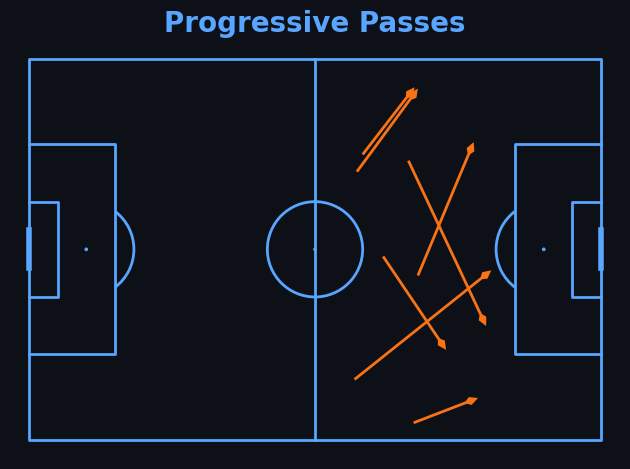

In [41]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Define colors
background_color = '#0d1117'
line_color = '#58a6ff'
arrow_color = '#f97316'
title_color = '#58a6ff'

# Create pitch (StatsBomb dimensions: 120x80)
pitch = Pitch(pitch_color=background_color, line_color=line_color,
              pitch_type='statsbomb', line_zorder=2, stripe=False)
fig, ax = pitch.draw()

# Drop rows with missing coordinates
progressive_passes = progressive_passes.dropna(subset=['x', 'y', 'endX', 'endY'])

# Filter out passes that go outside the pitch
progressive_passes = progressive_passes[
    (progressive_passes['x'] >= 0) & (progressive_passes['x'] <= 120) &
    (progressive_passes['y'] >= 0) & (progressive_passes['y'] <= 80) &
    (progressive_passes['endX'] >= 0) & (progressive_passes['endX'] <= 120) &
    (progressive_passes['endY'] >= 0) & (progressive_passes['endY'] <= 80)
]

# Draw arrows
for _, row in progressive_passes.iterrows():
    pitch.arrows(row['x'], row['y'], row['endX'], row['endY'],
                 width=2, headwidth=3, headlength=3, color=arrow_color, ax=ax)

# Styling
ax.set_title("Progressive Passes", fontsize=20, color=title_color, fontweight='bold')
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.tick_params(colors=line_color, which='both')
ax.xaxis.label.set_color(line_color)
ax.yaxis.label.set_color(line_color)

# Optional: remove spines if they don't exist
for spine in ['top', 'bottom', 'left', 'right']:
    if spine in ax.spines:
        ax.spines[spine].set_color(line_color)

plt.show()


In [42]:
mancity_df['type'].unique()

array(['Pass', 'Interception', 'BallRecovery', 'BallTouch', 'Foul',
       'TakeOn', 'Clearance', 'BlockedPass', 'CornerAwarded', 'Aerial',
       'SavedShot', 'Tackle', 'Save', 'KeeperPickup', 'Goal',
       'KeeperSweeper', 'Challenge', 'MissedShots', 'Card',
       'SubstitutionOff', 'SubstitutionOn', 'OffsideProvoked',
       'Dispossessed', 'ShotOnPost', 'Punch'], dtype=object)

**PLAYER HEAT MAP**

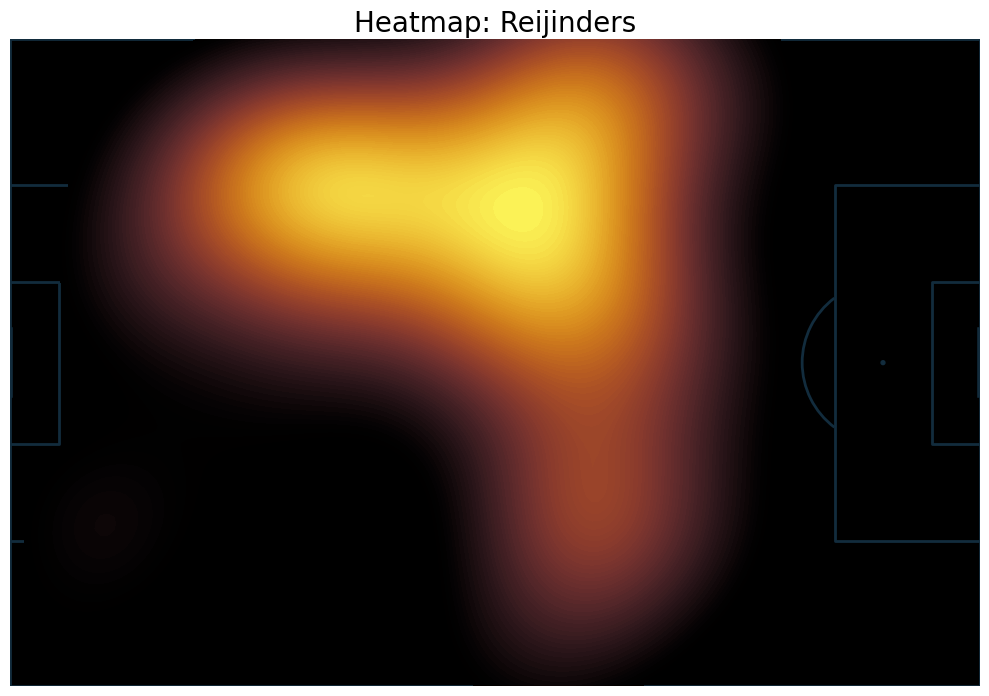

In [44]:
import cmasher as cmr

player_start_x=reijinders_df['x']
player_start_y=reijinders_df['y']
pitch = Pitch(pitch_type='statsbomb', pitch_color='black', line_color='#122c3d')
fig, ax = pitch.draw(figsize=(10, 7))


# Plot KDE heatmap with cmasher color map
sns.kdeplot(
    x=player_start_x, 
    y=player_start_y, 
    cmap=cmr.amber,  # Choose a color map from cmasher
    ax=ax,
    levels=100,
    fill=True,
    thresh=0.1
    
     # Adjust to filter out low-density areas
)

# Set axis limits to match pitch dimensions
ax.set_xlim(0, 120)
ax.set_ylim(0, 80)

# Add a title
ax.set_title('Heatmap: Reijinders', fontsize=20)

# Display the plot
plt.show()


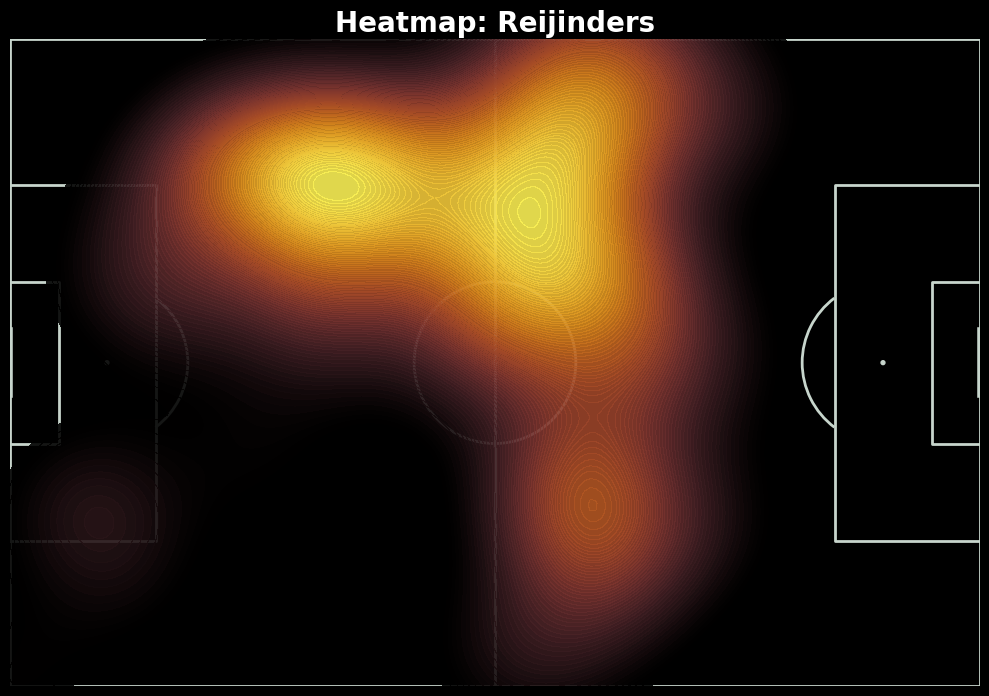

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import cmasher as cmr

# Extract coordinates
player_start_x = reijinders_df['x']
player_start_y = reijinders_df['y']

# Create pitch with StatsBomb dimensions (120x80)
pitch = Pitch(pitch_type='statsbomb', pitch_color='black', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(10, 7))

# Plot KDE heatmap
sns.kdeplot(
    x=player_start_x,
    y=player_start_y,
    cmap=cmr.amber,          # Opta-like vibrant colormap
    fill=True,               # Filled heatmap
    thresh=0.05,             # Hide extremely low-density regions
    levels=100,              # Smooth gradients
    alpha=0.9,               # Slight transparency for visual layering
    bw_adjust=0.8,           # Adjust smoothness of KDE
    ax=ax
)

# Set pitch bounds
ax.set_xlim(0, 120)
ax.set_ylim(0, 80)

# Optional: remove ticks and axis for cleaner look
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Title
ax.set_title('Heatmap: Reijinders', fontsize=20, color='white', weight='bold')

# Set figure face color
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

plt.tight_layout()
plt.show()


In [47]:
rayan_df=mancity_df[mancity_df['name']=='Rayan Aït-Nouri']

In [48]:
rayan_df.head()

,Unnamed: 0_x,id,eventId,minute,second,teamId_x,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,isGoal,cardType,Unnamed: 0_y,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId_y
21,31,2.825189e+09,24,1,16.0,167,62.9,96.8,1,FirstHalf,Pass,Successful,Length,"[91, 119, 117, 30, 36, 38, 216, 218]",True,355401.0,64.8,88.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,21,Rayan Aït-Nouri,DL,180,70,24,True,False,home,"{'possession': {'1': 2.0, '2': 1.0, '4': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,167
29,40,2.825189e+09,32,1,49.0,167,62.7,77.7,1,FirstHalf,Pass,Successful,Angle,"[91, 119, 117, 30, 205, 36, 37, 217, 218]",True,355401.0,68.7,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,21,Rayan Aït-Nouri,DL,180,70,24,True,False,home,"{'possession': {'1': 2.0, '2': 1.0, '4': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,167
43,62,2.825189e+09,46,2,57.0,167,62.9,69.9,2,FirstHalf,Pass,Successful,Zone,"[91, 119, 117, 30, 35, 38, 216, 218]",True,355401.0,53.6,44.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,21,Rayan Aït-Nouri,DL,180,70,24,True,False,home,"{'possession': {'1': 2.0, '2': 1.0, '4': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,167
63,91,2.825189e+09,65,4,28.0,167,80.1,81.5,4,FirstHalf,Pass,Successful,PassEndX,"[91, 119, 117, 30, 205, 35, 38, 217, 218]",True,355401.0,73.3,73.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,21,Rayan Aït-Nouri,DL,180,70,24,True,False,home,"{'possession': {'1': 2.0, '2': 1.0, '4': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,167
80,119,2.825189e+09,83,6,17.0,167,68.7,81.3,6,FirstHalf,Pass,Successful,PassEndX,"[91, 119, 117, 30, 35, 38, 216, 218]",True,355401.0,66.0,71.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,21,Rayan Aït-Nouri,DL,180,70,24,True,False,home,"{'possession': {'1': 2.0, '2': 1.0, '4': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,167


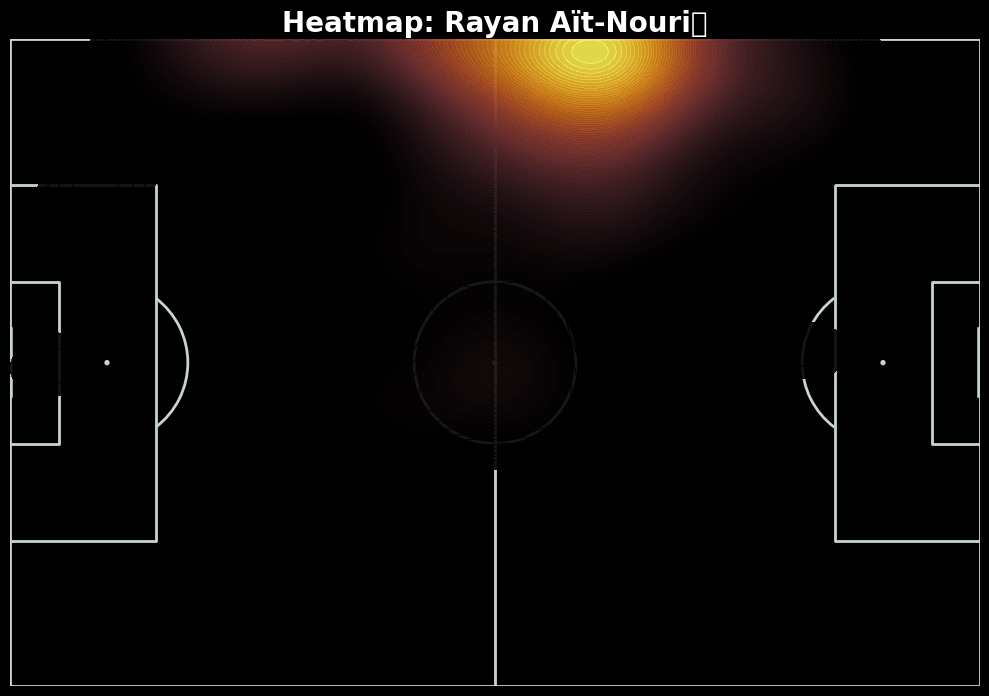

In [52]:
player_start_x=rayan_df['x']
player_start_y=rayan_df['y']


# Create pitch with StatsBomb dimensions (120x80)
pitch = Pitch(pitch_type='statsbomb', pitch_color='black', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(10, 7))

# Plot KDE heatmap
sns.kdeplot(
    x=player_start_x,
    y=player_start_y,
    cmap=cmr.amber,          # Opta-like vibrant colormap
    fill=True,               # Filled heatmap
    thresh=0.05,             # Hide extremely low-density regions
    levels=100,              # Smooth gradients
    alpha=0.9,               # Slight transparency for visual layering
    bw_adjust=0.8,           # Adjust smoothness of KDE
    ax=ax
)

# Set pitch bounds
ax.set_xlim(0, 120)
ax.set_ylim(0, 80)

# Optional: remove ticks and axis for cleaner look
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Title
ax.set_title('Heatmap: Rayan Aït-Nouri	', fontsize=20, color='white', weight='bold')

# Set figure face color
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

plt.tight_layout()
plt.show()


In [53]:
gvardiol_df=mancity_df[mancity_df['name']=='Josko Gvardiol']

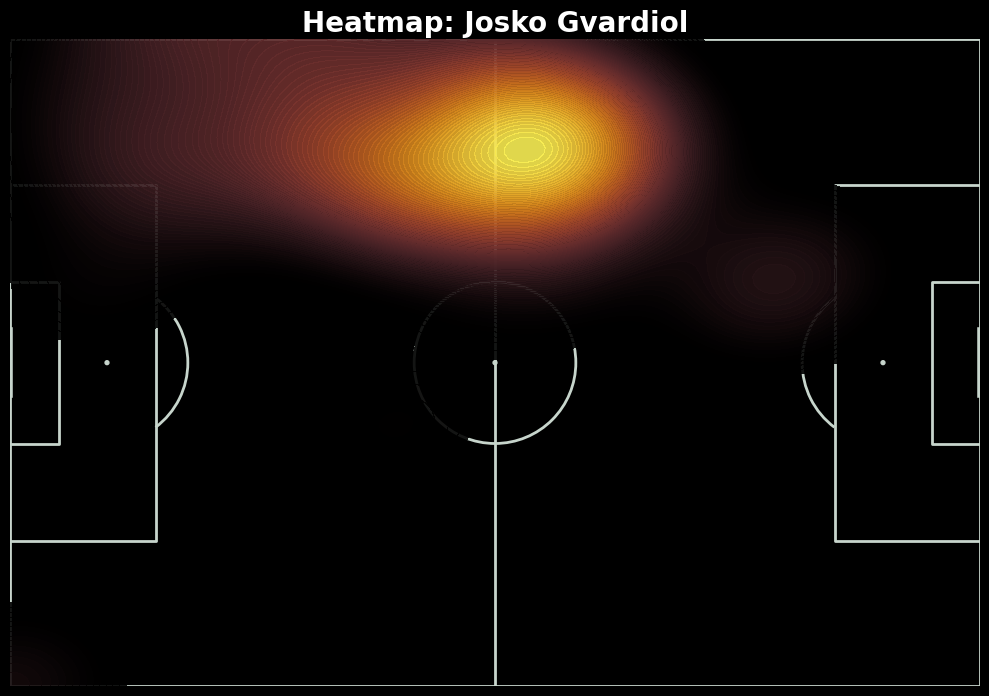

In [55]:
player_start_x=gvardiol_df['x']
player_start_y=gvardiol_df['y']

# Create pitch with StatsBomb dimensions (120x80)
pitch = Pitch(pitch_type='statsbomb', pitch_color='black', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(10, 7))

# Plot KDE heatmap
sns.kdeplot(
    x=player_start_x,
    y=player_start_y,
    cmap=cmr.amber,          # Opta-like vibrant colormap
    fill=True,               # Filled heatmap
    thresh=0.05,             # Hide extremely low-density regions
    levels=100,              # Smooth gradients
    alpha=0.9,               # Slight transparency for visual layering
    bw_adjust=0.8,           # Adjust smoothness of KDE
    ax=ax
)

# Set pitch bounds
ax.set_xlim(0, 120)
ax.set_ylim(0, 80)

# Optional: remove ticks and axis for cleaner look
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Title
ax.set_title('Heatmap: Josko Gvardiol', fontsize=20, color='white', weight='bold')

# Set figure face color
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

plt.tight_layout()
plt.show()


In [ ]:
# create functions for the above

